# Forecasting of customer churn in a hotel chain

## Introduction

The hotel chain added an opportunity of booking without prepayment. By using such system there is a risk of loss due to cancellations. We have a task to develop a system for predicting booking cancellations. If model forecasts a cancellation of the reservation, then this client will be asked to make a deposit in the amount of 80% of the cost.

We have files with data, one of them is for training a model, the other - to test it. We'll study the data and if necessary do preposcessing. Before creating of a model, we'll do EDA and make some conclusions based on the EDA. After that we are going to create a ML model.

### Additional information

There are several types of rooms in the hotel chain and depending on this there are different prices for one night. There is also cleaning costs. If the client rents a room for a long time, then cleaning performs every two days 

- category A: price per night — 1 000, one-time maintenance — 400;
- category B: price per night — 800, one-time maintenance — 350;
- category C: price per night — 600, one-time maintenance — 350;
- category D: price per night — 550, one-time maintenance — 150;
- category E: price per night — 500, one-time maintenance — 150;
- category F: price per night — 450, one-time maintenance — 150;
- category G: price per night — 350, one-time maintenance — 150.

The hotel chain uses season coefficients:

- Sprint, Autumn: prices increase by 20%
- Summer: prices increase на 40%

For losses in case of cancellation of the reservation we'll count cost of one-time maintenance and one night according to the season coefficient.

A budget for development of the system is 400k. Implementation should pay off during the test period

## Reading the files with data

**Importing of necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 

from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Reading the files**

In [2]:
hotels_train = pd.read_csv('hotel_train.csv')
hotels_test = pd.read_csv('hotel_test.csv')

**Basic information about datasets**

In [3]:
hotels_train.info()
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [4]:
pd.set_option('display.max_columns', 50)
display(hotels_train.head(10))
display(hotels_test.head(10))

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3
5,5,1,75.0,2015,July,27,1,0,3,2.0,0.0,0.0,HB,PRT,TA/TO,0,0,0,D,0,0,Transient,0,0,3
6,6,1,23.0,2015,July,27,1,0,4,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,E,0,0,Transient,0,0,4
7,7,0,18.0,2015,July,27,1,0,4,2.0,1.0,0.0,HB,ESP,TA/TO,0,0,0,G,1,0,Transient,0,1,4
8,8,0,68.0,2015,July,27,1,0,4,2.0,0.0,0.0,BB,IRL,TA/TO,0,0,0,D,0,0,Transient,0,3,4
9,9,0,37.0,2015,July,27,1,0,4,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,E,0,0,Contract,0,0,4


,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7
5,6091,1,52.0,2017,January,1,1,2,5,1.0,0.0,0.0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,7
6,6092,1,143.0,2017,January,1,2,1,1,2.0,0.0,0.0,BB,BRA,Direct,0,0,0,A,1,0,Transient,0,1,2
7,6093,1,21.0,2017,January,1,2,1,3,2.0,0.0,0.0,BB,BRA,TA/TO,0,0,0,A,0,0,Transient,0,1,4
8,6094,1,89.0,2017,January,1,2,1,3,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,E,0,0,Transient,0,0,4
9,6095,1,48.0,2017,January,1,2,1,4,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,A,1,0,Transient,0,2,5


- Both datasets have 25 columns. Training data has 65229 strings, test data - 32412 strings.
- Columns `lead_time`, `adults`, `children`, `babies` have to be in integer format, here we have float type. During prepocessing we'll look into it.

Checked the basic information the datasets contain, now we have start doing preprocessing and EDA.

## Preprocessing and Exploratory Data Analysis

### Missed data

Take a look if there is missed data.

In [5]:
hotels_train.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [6]:
hotels_test.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

No missed data. Let's check for duplicate values.

### Duplicate values

#### Explicit duplicate values

In [7]:
hotels_train.duplicated().sum()

0

In [8]:
hotels_test.duplicated().sum()

0

There are no explicit duplicate values.

#### Implicit duplicate values

Now we are going to check columns that potentialy can contain implicit duplicate values: `arrival_date_month`, `meal`, `country`, `distribution_channel`, `reserved_room_type`, `customer_type`


In [9]:
display(hotels_train['arrival_date_month'].unique())
display(hotels_test['arrival_date_month'].unique())

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

Column `arrival_date_month` contains correct values.

In [10]:
display(hotels_train['meal'].unique())
display(hotels_test['meal'].unique())

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

Column `meal` has implicit duplicate values, also there are some extra spaces. We'll revome these extra spaces.

In [11]:
hotels_train['meal'] = hotels_train['meal'].str.strip()
hotels_test['meal'] = hotels_test['meal'].str.strip()

In [12]:
display(hotels_train['meal'].unique())
display(hotels_test['meal'].unique())

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

After removing of extra spaces, we've got rid off implicit duplicate values.

In [13]:
display(hotels_train['country'].unique())
display(hotels_test['country'].unique())

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'CN', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL',
       'EST', 'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA',
       'SVN', 'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT',
       'LTU', 'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA',
       'KOR', 'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB',
       'JEY', 'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA',
       'DOM', 'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS',
       'BIH', 'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR',
       'SYR', 'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE',
       'PLW', 'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP',
       'TWN', 'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ',
       'AND', 'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD',
       'ISL', 'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA',
       'GAB', 'MKD', 

array(['PRT', 'AUT', 'BEL', 'DEU', 'BRA', 'GBR', 'ESP', 'FRA', 'ITA',
       'LUX', 'CHE', 'EST', 'NGA', 'IRL', 'CN', 'POL', 'AUS', 'NLD',
       'KOR', 'ROU', 'USA', 'CHL', 'DNK', 'FIN', 'RUS', 'SWE', 'HUN',
       'HRV', 'MDV', 'ZAF', 'ISR', 'NOR', 'CHN', 'ARE', 'MAR', 'COL',
       'FJI', 'LVA', 'LBN', 'PHL', 'HKG', 'SYC', 'GIB', 'AGO', 'MYS',
       'MDG', 'IDN', 'LTU', 'ISL', 'TUR', 'ARG', 'JPN', 'SVN', 'SVK',
       'BGR', 'CAF', 'JAM', 'UZB', 'UKR', 'IND', 'CZE', 'URY', 'NZL',
       'NPL', 'SRB', 'CPV', 'IRN', 'KAZ', 'BHS', 'SUR', 'CUB', 'PAK',
       'MAC', 'CYP', 'JOR', 'GRC', 'KWT', 'TWN', 'VNM', 'SGP', 'DOM',
       'VEN', 'SEN', 'BLR', 'TZA', 'LIE', 'GNB', 'SAU', 'DZA', 'PER',
       'AZE', 'EGY', 'ETH', 'KEN', 'THA', 'MLT', 'ECU', 'AND', 'IMN',
       'BHR', 'TUN', 'MNE', 'MEX', 'BEN', 'MOZ', 'UMI', 'JEY', 'MYT',
       'QAT', 'BGD', 'GAB', 'CIV', 'ZWE', 'GTM', 'ALB', 'GHA', 'ATA',
       'ASM', 'PAN', 'CRI', 'MCO', 'MUS', 'SYR', 'TGO', 'IRQ', 'LKA',
       'BIH', 'PRY', 

Column `country` contains correct values.

In [14]:
display(hotels_train['distribution_channel'].unique())
display(hotels_test['distribution_channel'].unique())

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

Column `distribution_channel` contains correct values.

In [15]:
display(hotels_train['reserved_room_type'].unique())
display(hotels_test['reserved_room_type'].unique())

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

Column `reserved_room_type` has correct values, but there are some extra spaces, we'll revome them.

In [16]:
hotels_train['reserved_room_type'] = hotels_train['reserved_room_type'].str.strip()
hotels_test['reserved_room_type'] = hotels_test['reserved_room_type'].str.strip()

In [17]:
display(hotels_train['reserved_room_type'].unique())
display(hotels_test['reserved_room_type'].unique())

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

Extra spaces are removed.

In [18]:
display(hotels_train['customer_type'].unique())
display(hotels_test['customer_type'].unique())

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

Column `customer_type` contains correct values.

### Changing of data types

Previously we've noticed that columns `lead_time`, `adults`, `children`, `babies` have float type, but they have to be in integer type. We'are going to change the type for correct one.

In [19]:
hotels_train['lead_time'] = hotels_train['lead_time'].astype('int16')
hotels_train['adults'] = hotels_train['adults'].astype('int8')
hotels_train['children'] = hotels_train['children'].astype('int8')
hotels_train['babies'] = hotels_train['babies'].astype('int8')

hotels_test['lead_time'] = hotels_test['lead_time'].astype('int16')
hotels_test['adults'] = hotels_test['adults'].astype('int8')
hotels_test['children'] = hotels_test['children'].astype('int8')
hotels_test['babies'] = hotels_test['babies'].astype('int8')

Also, let's adjust other integer columns. They have int64 type, which is redundantly considering the values they have, we'll chenge them to int16 and int8.

In [20]:
hotels_train['is_canceled'] = hotels_train['is_canceled'].astype('int8')
hotels_train['arrival_date_year'] = hotels_train['arrival_date_year'].astype('int16')
hotels_train['arrival_date_week_number'] = hotels_train['arrival_date_week_number'].astype('int8')
hotels_train['arrival_date_day_of_month'] = hotels_train['arrival_date_day_of_month'].astype('int8')
hotels_train['stays_in_weekend_nights'] = hotels_train['stays_in_weekend_nights'].astype('int8')
hotels_train['stays_in_week_nights'] = hotels_train['stays_in_week_nights'].astype('int8')
hotels_train['is_repeated_guest'] = hotels_train['is_repeated_guest'].astype('int8')
hotels_train['previous_cancellations'] = hotels_train['previous_cancellations'].astype('int8')
hotels_train['previous_bookings_not_canceled'] = hotels_train['previous_bookings_not_canceled'].astype('int8')
hotels_train['booking_changes'] = hotels_train['booking_changes'].astype('int8')
hotels_train['days_in_waiting_list'] = hotels_train['days_in_waiting_list'].astype('int16')
hotels_train['required_car_parking_spaces'] = hotels_train['required_car_parking_spaces'].astype('int8')
hotels_train['total_of_special_requests'] = hotels_train['total_of_special_requests'].astype('int8')
hotels_train['total_nights'] = hotels_train['total_nights'].astype('int8')

hotels_test['is_canceled'] = hotels_test['is_canceled'].astype('int8')
hotels_test['arrival_date_year'] = hotels_test['arrival_date_year'].astype('int16')
hotels_test['arrival_date_week_number'] = hotels_test['arrival_date_week_number'].astype('int8')
hotels_test['arrival_date_day_of_month'] = hotels_test['arrival_date_day_of_month'].astype('int8')
hotels_test['stays_in_weekend_nights'] = hotels_test['stays_in_weekend_nights'].astype('int8')
hotels_test['stays_in_week_nights'] = hotels_test['stays_in_week_nights'].astype('int8')
hotels_test['is_repeated_guest'] = hotels_test['is_repeated_guest'].astype('int8')
hotels_test['previous_cancellations'] = hotels_test['previous_cancellations'].astype('int8')
hotels_test['previous_bookings_not_canceled'] = hotels_test['previous_bookings_not_canceled'].astype('int8')
hotels_test['booking_changes'] = hotels_test['booking_changes'].astype('int8')
hotels_test['days_in_waiting_list'] = hotels_test['days_in_waiting_list'].astype('int16')
hotels_test['required_car_parking_spaces'] = hotels_test['required_car_parking_spaces'].astype('int8')
hotels_test['total_of_special_requests'] = hotels_test['total_of_special_requests'].astype('int8')
hotels_test['total_nights'] = hotels_test['total_nights'].astype('int8')

In [21]:
hotels_train.info()
hotels_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              65229 non-null  int64 
 1   is_canceled                     65229 non-null  int8  
 2   lead_time                       65229 non-null  int16 
 3   arrival_date_year               65229 non-null  int16 
 4   arrival_date_month              65229 non-null  object
 5   arrival_date_week_number        65229 non-null  int8  
 6   arrival_date_day_of_month       65229 non-null  int8  
 7   stays_in_weekend_nights         65229 non-null  int8  
 8   stays_in_week_nights            65229 non-null  int8  
 9   adults                          65229 non-null  int8  
 10  children                        65229 non-null  int8  
 11  babies                          65229 non-null  int8  
 12  meal                            65229 non-null

Now all columns have correct types.

### Anomalies

We'll check if there are anomalies in the data. For start we'll take a look on histograms for all columns.

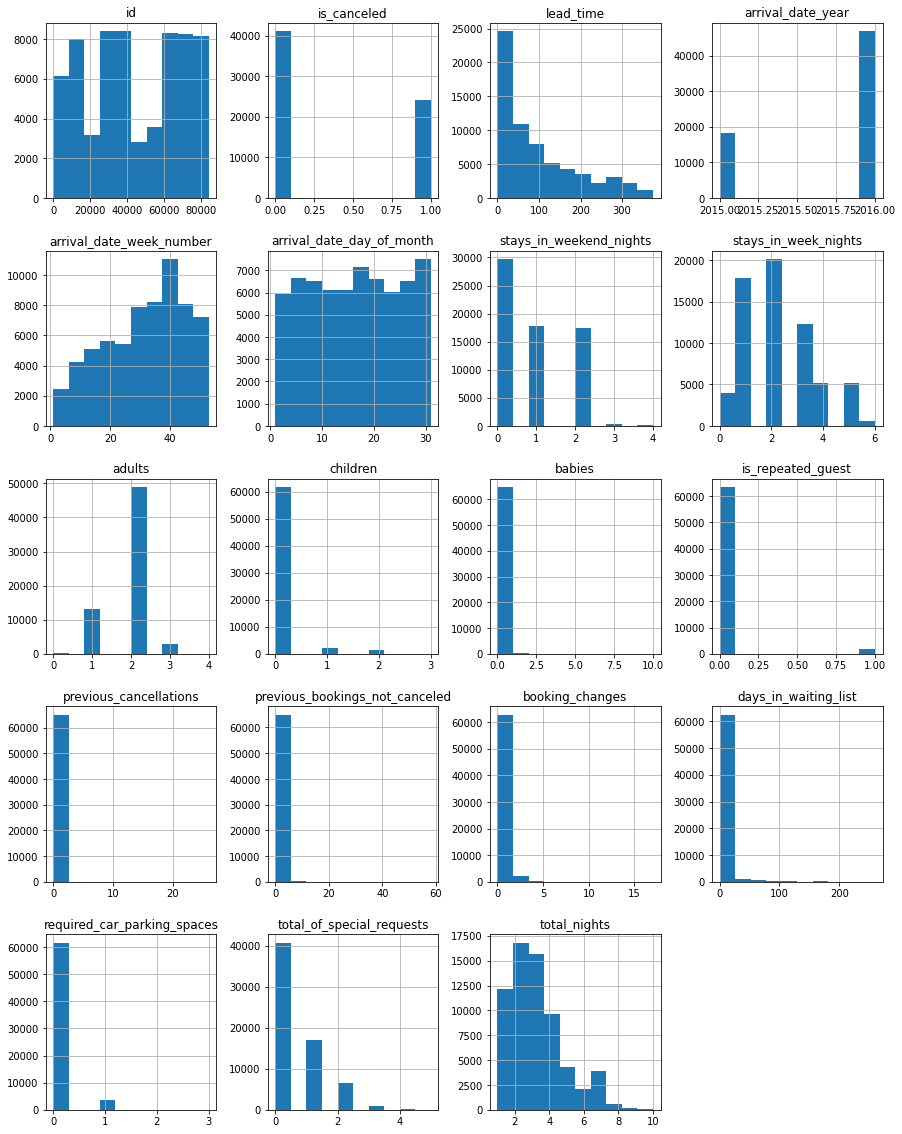

In [22]:
hotels_train.hist(figsize=(15, 20));

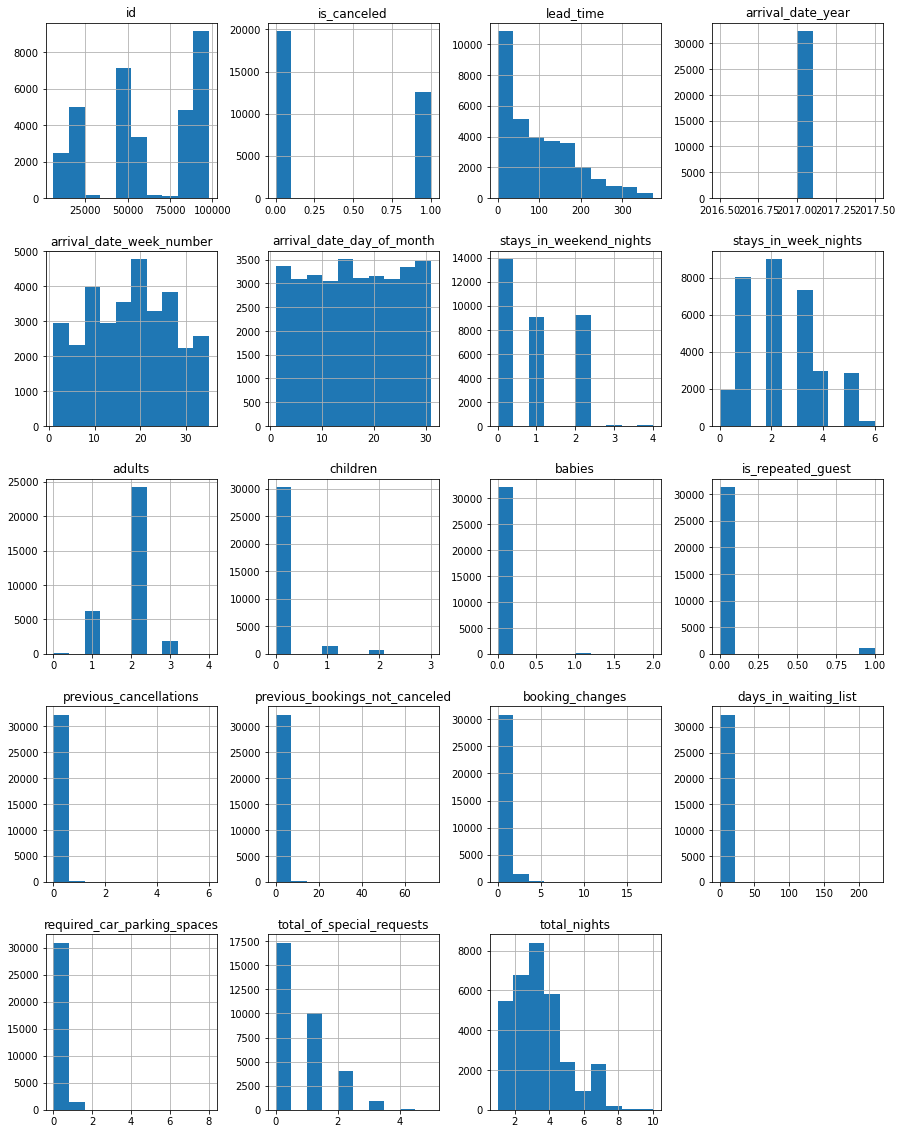

In [23]:
hotels_test.hist(figsize=(15, 20));

In training data we can see that column `babies` has values up to 10, while test data hos only up to 2. Let's check the values they have.

In [24]:
display(hotels_train['babies'].sort_values().unique())
display(hotels_test['babies'].sort_values().unique())

array([ 0,  1,  2,  9, 10], dtype=int8)

array([0, 1, 2], dtype=int8)

We can see that both datasets have values 0, 1, 2, but the training dataset also has 9 and 10. Those values most probably are anomalies. Let's check how many are they.

In [25]:
hotels_train.query('babies > 2').sort_values(by='babies')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
41528,59925,0,11,2015,October,42,11,2,1,1,0,9,BB,GBR,Corporate,0,0,0,A,1,0,Transient-Party,0,0,3
22995,30935,0,37,2016,January,3,12,0,2,2,0,10,BB,PRT,TA/TO,0,0,0,D,1,0,Transient,0,1,2


We've found two string, we'll delete them.

In [26]:
hotels_train = hotels_train.query('babies <= 2').reset_index(drop=True)

In [27]:
display(hotels_train['babies'].sort_values().unique())

array([0, 1, 2], dtype=int8)

Anomalies in column `babies` have been deleted.

We can see potential anomalies in column `required_car_parking_spaces` in test dataset.

In [28]:
display(hotels_train['required_car_parking_spaces'].sort_values().unique())
display(hotels_test['required_car_parking_spaces'].sort_values().unique())

array([0, 1, 2, 3], dtype=int8)

array([0, 1, 2, 3, 8], dtype=int8)

For both datasets typical values are 0, 1, 2, 3. But the test dataset also has 8, let's take a look how many are they.

In [29]:
hotels_test.query('required_car_parking_spaces > 3').sort_values(by='required_car_parking_spaces')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2549,17717,0,26,2017,March,11,14,0,5,2,0,0,HB,AUT,Corporate,1,0,2,E,1,0,Transient-Party,8,1,5
2550,17718,0,138,2017,March,12,19,2,2,2,0,0,HB,AUT,Corporate,1,0,2,E,1,122,Transient-Party,8,0,4


We've found two string, we'll delete them.

In [30]:
hotels_test = hotels_test.query('required_car_parking_spaces <= 3').reset_index(drop=True)

In [31]:
display(hotels_test['required_car_parking_spaces'].sort_values().unique())

array([0, 1, 2, 3], dtype=int8)

Anomalies in column `babies` have been deleted.

Column `adults` has values 0, those strings must be anomalies, let's take a look how many are they.

In [32]:
display(hotels_train['adults'].sort_values().unique())
display(hotels_test['adults'].sort_values().unique())

array([0, 1, 2, 3, 4], dtype=int8)

array([0, 1, 2, 3, 4], dtype=int8)

In [33]:
hotels_train.query('adults < 1')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
17540,25480,0,1,2015,August,33,10,1,1,0,3,0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,0,2
17598,25538,0,104,2015,August,33,11,0,3,0,2,0,BB,FRA,TA/TO,0,0,0,B,1,0,Transient-Party,0,2,3
17982,25922,0,3,2015,August,34,16,2,0,0,2,0,BB,PRT,Direct,0,0,0,B,1,0,Transient-Party,0,1,2
21556,29496,1,48,2015,October,43,19,1,3,0,2,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,4
22516,30456,1,6,2015,December,51,13,1,0,0,3,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient-Party,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64749,83478,0,197,2016,December,52,21,1,4,0,3,0,HB,FRA,TA/TO,0,0,0,A,7,0,Transient-Party,0,0,5
64880,83610,0,104,2016,December,53,25,2,1,0,2,0,BB,PRT,TA/TO,0,0,0,B,1,0,Transient,0,2,3
64890,83620,0,104,2016,December,53,25,2,1,0,2,0,BB,FRA,TA/TO,0,0,0,B,0,0,Transient,0,2,3
64901,83633,0,247,2016,December,52,24,2,3,0,2,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient,0,1,5


In [34]:
hotels_test.query('adults < 1')

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
7741,44932,1,111,2017,January,1,2,1,3,0,2,0,BB,RUS,TA/TO,0,0,0,B,0,0,Transient,0,2,4
7749,44940,1,268,2017,January,1,2,1,4,0,2,0,BB,RUS,TA/TO,0,0,0,B,0,0,Transient,0,1,5
8770,45961,1,148,2017,February,6,5,2,5,0,2,0,BB,FRA,TA/TO,0,0,0,B,0,0,Transient,0,2,7
9241,46432,1,134,2017,February,8,22,2,4,0,2,0,BB,BRA,TA/TO,0,0,0,B,0,0,Transient,0,1,6
9303,46494,1,148,2017,February,8,24,2,2,0,2,0,BB,BRA,TA/TO,0,0,0,B,1,0,Transient,0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30599,96093,0,296,2017,July,30,27,1,3,0,2,0,BB,GBR,TA/TO,0,0,0,B,0,0,Transient,0,1,4
30652,96146,0,276,2017,July,31,30,2,1,0,2,0,BB,DEU,TA/TO,0,0,0,B,1,0,Transient,0,2,3
30676,96170,0,291,2017,July,30,29,2,2,0,2,0,BB,PRT,TA/TO,0,0,0,B,0,0,Transient,0,1,4
30813,96307,0,159,2017,July,31,31,1,3,0,2,0,SC,FRA,TA/TO,0,0,0,A,1,0,Transient,0,1,4


We've found 166 strings in training dataset and 69 in test dataset. We'll delete them.
Нашли 166 строк в тренировочном датасете и 69 в тестовом. Удалим их.

In [35]:
hotels_train = hotels_train.query('adults > 0').reset_index(drop=True)
hotels_test = hotels_test.query('adults > 0').reset_index(drop=True)

### Preprocessing conclusion

We've checked datasets for missing values, duplicates, anomalies also cheched if data types in columns are correct.

- There were no missing values in the data.
- We check both explicit and implicit duplicates.
 - No explicit duplicates were found.
 - We've found implicit duplicates in column `meal` also this column was incorrectly filled. Same problems had column `reserved_room_type`. We've fixed it, now there are no duplicates in the data.
- We've revealed anomalies in three columns `babies`, `required_car_parking_spaces` and `adults`. In total 239 abnormal strings, 168 - from training dataset and 71 - from test dataset. We've deleted these strings.

Now the prepocessing is finished. We can start Exploratory Data Analysis.

### Exploratory Data Analysis

**Booking cancellation**

We'll take a look at canceled, not canceled booking ratio.

0    0.631177
1    0.368823
Name: is_canceled, dtype: float64


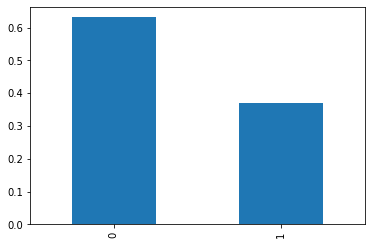

In [36]:
class_frequency = hotels_train['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

0    0.611638
1    0.388362
Name: is_canceled, dtype: float64


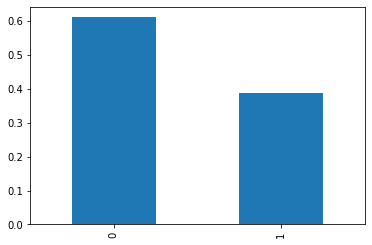

In [37]:
class_frequency = hotels_test['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

There is a slight class disbalance, but it's not critical. 63% and 61% are not canceled bookings in training and test datasets respectively. 37% and 39% - canceled.

**Time between booking and arrival**

We'll make histograms and take a look how values are disturbed in column `lead_time`

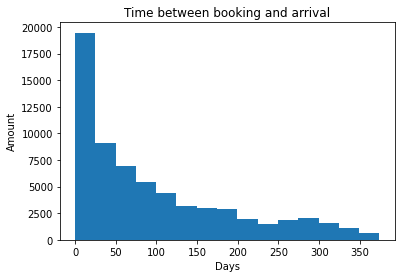

In [38]:
fig, ax = plt.subplots()
ax.hist(hotels_train['lead_time'], bins=15);
ax.set_title('Time between booking and arrival')
ax.set_xlabel('Days')
ax.set_ylabel('Amount')
plt.show()

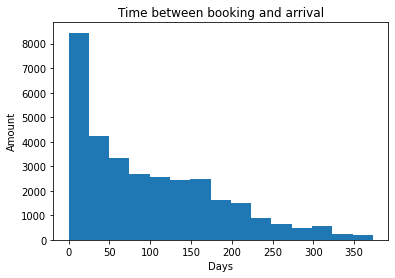

In [39]:
fig, ax = plt.subplots()
ax.hist(hotels_test['lead_time'], bins=15);
ax.set_title('Time between booking and arrival')
ax.set_xlabel('Days')
ax.set_ylabel('Amount')
plt.show()

We can see that the most of the values are located closer towards 0 days and there is a long tail towards a year. This kind of distribution looks logical for this column.

**Arrival month**

Let's take a look which months are the most popular and which are less.

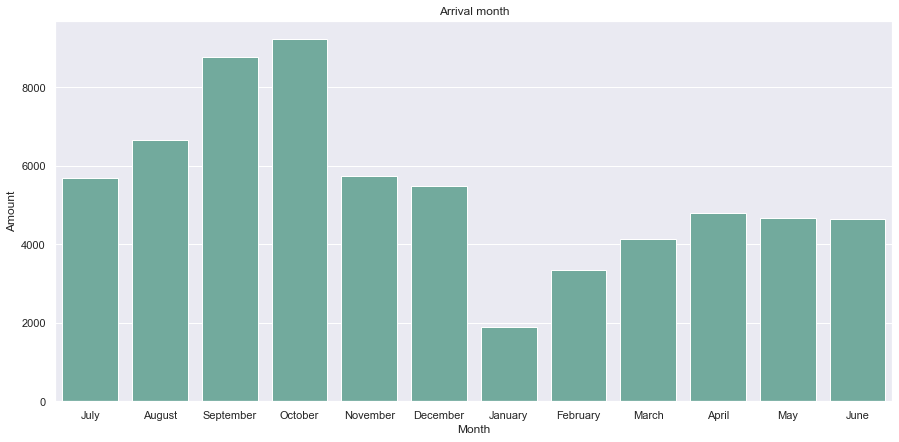

In [40]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='arrival_date_month', 
    y=hotels_train.index, 
    data=hotels_train, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Arrival month');
plt.xlabel('Month');
plt.ylabel('Amount');

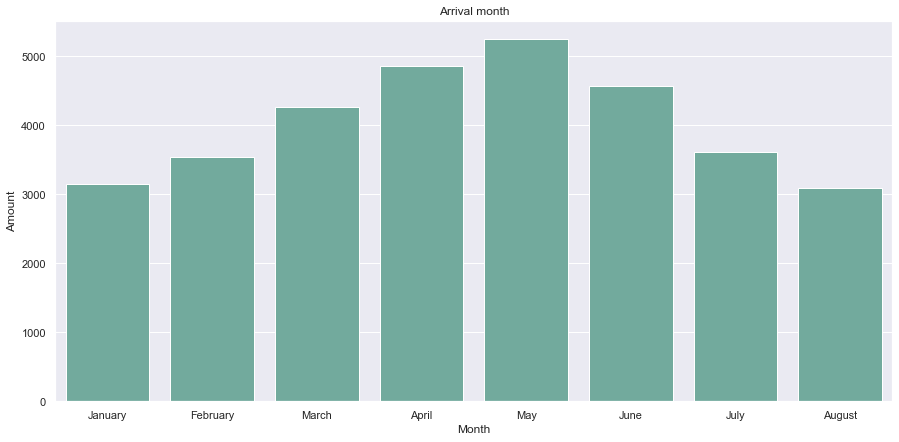

In [41]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='arrival_date_month', 
    y=hotels_test.index, 
    data=hotels_test, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Arrival month');
plt.xlabel('Month');
plt.ylabel('Amount');

First two months of autumn are the most popular, and January and Februare are the least popular. Such conclusion we can make based on training data. In the test dataset we have data only for first 8 months.

Let's take a look for the months with the most cancelations.

In [42]:
hotels_train.pivot_table(index='arrival_date_month',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
arrival_date_month,
June,0.414750
September,0.396762
April,0.392909
August,0.389499
July,0.388704
October,0.385798
May,0.358046
February,0.352572
December,0.348302


In [43]:
hotels_test.pivot_table(index='arrival_date_month',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
arrival_date_month,
June,0.448623
April,0.445427
May,0.439558
July,0.367313
August,0.355642
January,0.340229
March,0.329348
February,0.319955


The most often booking was canceled in June and April. The less - in the beginning of the year: January, February, March.

**Repeated clients**

Let's take a look for amount of repeated clients and the connection with booking cancellation.

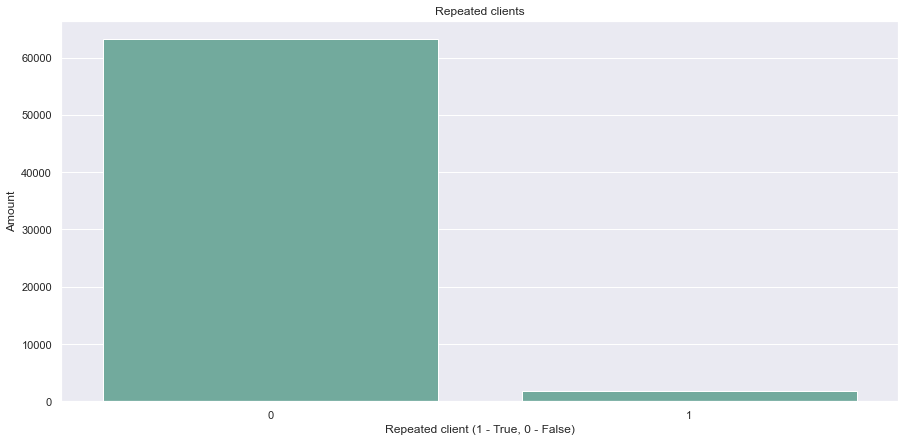

In [44]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='is_repeated_guest', 
    y=hotels_train.index, 
    data=hotels_train, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Repeated clients');
plt.xlabel('Repeated client (1 - True, 0 - False)');
plt.ylabel('Amount');

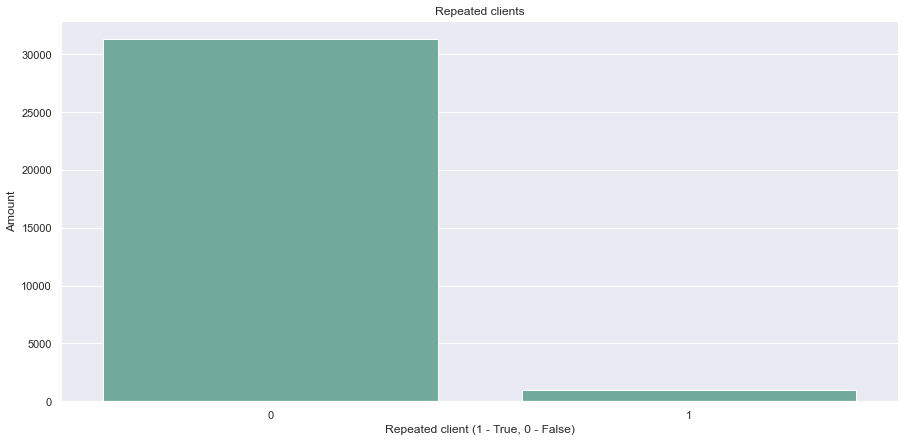

In [45]:
sns.set(style="darkgrid")

plt.figure(figsize=(15, 7))
sns.barplot(
    x='is_repeated_guest', 
    y=hotels_test.index, 
    data=hotels_test, 
    estimator=len, 
    ci=None, 
    color='#69b3a2');
plt.title('Repeated clients');
plt.xlabel('Repeated client (1 - True, 0 - False)');
plt.ylabel('Amount');

In [46]:
hotels_train.pivot_table(index='is_repeated_guest',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
is_repeated_guest,
0,0.372075
1,0.252542


In [47]:
hotels_test.pivot_table(index='is_repeated_guest',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
is_repeated_guest,
0,0.399355
1,0.048371


Most of the client book for the first time. Those clients who are booking not for the first time are less likely to cancel.

**Total amount of nights**

Let's check is there a connection between amount of nights and cancellation.

In [48]:
hotels_train.pivot_table(index='total_nights',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
total_nights,
2,0.451542
6,0.410740
9,0.403974
3,0.402319
4,0.349771
8,0.338262
10,0.322034
7,0.318087
5,0.313188


In [49]:
hotels_test.pivot_table(index='total_nights',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
total_nights,
3,0.457214
2,0.424067
8,0.415094
4,0.390181
5,0.383430
6,0.377540
7,0.365950
10,0.345455
9,0.290323


Results in both datasets are different, but the is a one common feature. Those who book for one night are less likely to cancel.

In [50]:
train_plot = hotels_train.groupby('total_nights').agg(mean=('is_canceled', 'mean'))
test_plot = hotels_test.groupby('total_nights').agg(mean=('is_canceled', 'mean'))

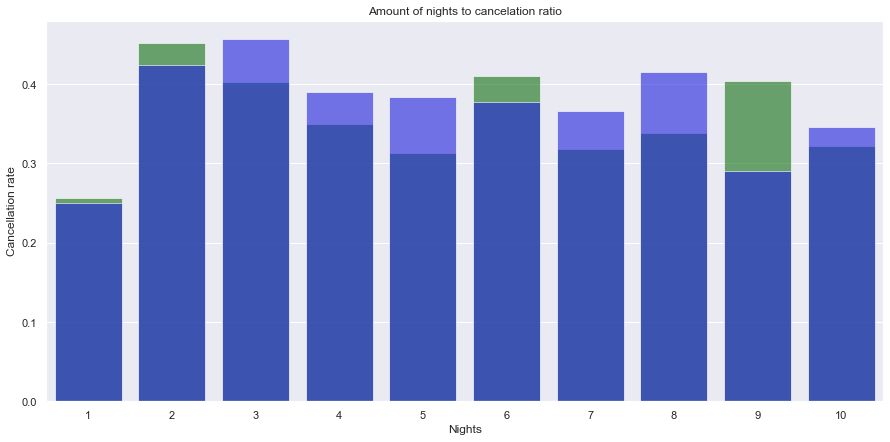

In [51]:
sns.set(style="darkgrid")
plt.figure(figsize=(15, 7))

sns.barplot(
    x=train_plot.index, 
    y='mean', 
    data=train_plot, 
    estimator=sum, 
    ci=None,
    alpha=0.6,
    color='green');


sns.barplot(
    x=test_plot.index, 
    y='mean', 
    data=test_plot, 
    estimator=sum, 
    ci=None,
    alpha=0.6,
    color='blue');

plt.title('Amount of nights to cancelation ratio');
plt.xlabel('Nights');
plt.ylabel('Cancellation rate');

**Distribution channel**

We're going to check if distribution channel has effect on cancellation.

In [52]:
hotels_train.pivot_table(index='distribution_channel',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
distribution_channel,
TA/TO,0.404401
Corporate,0.217482
GDS,0.191919
Direct,0.173181


In [53]:
hotels_test.pivot_table(index='distribution_channel',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
distribution_channel,
TA/TO,0.426081
Corporate,0.256410
Direct,0.171161
GDS,0.164706


Result with both datasets are approximately the same. TA/TO is the most unreliable channel. Direct и GDS are the most reliable. Corporate is closer towards Direct and GDS.

**Customer type**

Let's check if customer type has an impact on cancellations.

In [54]:
hotels_train.pivot_table(index='customer_type',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
customer_type,
Contract,0.397086
Transient,0.396269
Transient-Party,0.294125
Group,0.083916


In [55]:
hotels_test.pivot_table(index='customer_type',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
customer_type,
Transient,0.429692
Transient-Party,0.165987
Contract,0.125348
Group,0.048485


We can make a conclusion that the group check-in is the most reliable type. Other types are quite different, we can't make any unambiguous conclusions based on the data we have.

**Special requests**

Let's check if special requests have an imapct on cancellations.

In [56]:
hotels_train.pivot_table(index='total_of_special_requests',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
total_of_special_requests,
0,0.479599
3,0.196307
2,0.194423
1,0.181000
4,0.123810
5,0.000000


In [57]:
hotels_test.pivot_table(index='total_of_special_requests',
                         values='is_canceled',
                         aggfunc='mean') \
.sort_values(by='is_canceled', ascending=False)

,is_canceled
total_of_special_requests,
0,0.494688
1,0.278793
2,0.260771
3,0.169811
4,0.104839
5,0.055556


We can make a conclusion that clients that don't have any special requests are more likely to cancel then those who has at least one special request.

### Exploratory Data Analysis conclusion

We've checked how different data can have an impact on cancellations.

- The most unreliable months are June and April, but first months of the year (January, February, March) are less likely to be canceled.
- Client that make reservation for the first time are less likely to cancel.
- Those how book one night are less likely to cancel.
- Found out that distribution chanel has an impact on cancellation. TA/TO is the most unreliable but Direct and GDS are the most reliable.
- Customer type also has an impact on cancellation. Group check-in is the most reliable type. We can't make conclusive conclusion about other types.
- Special requests have an impact on cancellation. Those clients that don't have requests are more likely to cancel.

Checked the class balance. There is a minor disvbalance in both datasets, but nothing critical.

## Formulation a ML-task based on business task

### Profit calculation excluding deposits

Let's calculate profit on the test dataset excluding deposits offered by the cancelation predictor system. That means if a client cancels reservation, the hotel chain losses money spent on one-time maintence.

We're going to calulate profit in the following way:

**Room price (considering if it was canceled or not) * Coefficient * Amount of nights - Maintenance costs * Amount of nights (considering if client books more then 2 nights then maintenance is going to be done once in two days)**

That way we can found out profit from each client.

Let's write the constants which we need to calculate profit.

In [58]:
BUDGET = 400000 # Budget allocated for the forecasting system

A_PRICE = 1000 # Price per night of different room categories
B_PRICE = 800
C_PRICE = 600
D_PRICE = 550
E_PRICE = 500
F_PRICE = 450
G_PRICE = 350

A_MAINTENANCE = 400 # One-time maintenance costs (considering categories)
B_MAINTENANCE = 350
C_MAINTENANCE = 350
D_MAINTENANCE = 150
E_MAINTENANCE = 150
F_MAINTENANCE = 150
G_MAINTENANCE = 150

SUMMER_COEF = 1.4 # Summer coefficient 
SPRING_FALL_COEF = 1.2 # Spring/Autumn coefficient

DEPOSIT = 0.8 # Deposit size

For more convinient work with the coefficents let's create two lists with summer and spring/autumn months.

In [59]:
summer = ['June', 'July', 'August']
spring_fall = ['March', 'April', 'May', 'September', 'October', 'November']

Let's write functions with which we add the season coefficients, room price (considering it's type), one-time maintenance (considering it's type) in a dataframe.

In [60]:
# Function for adding a season coefficient
def coef(season):
    if season in summer:
        return SUMMER_COEF
    elif season in spring_fall:
        return SPRING_FALL_COEF
    else:
        return 1

# Function for adding a price per night
def room_type(room_type):
    if room_type == 'A':
        return A_PRICE
    elif room_type == 'B':
        return B_PRICE
    elif room_type == 'C':
        return C_PRICE
    elif room_type == 'D':
        return D_PRICE
    elif room_type == 'E':
        return E_PRICE
    elif room_type == 'F':
        return F_PRICE
    elif room_type == 'G':
        return G_PRICE

# Function for adding one-time maintenance
def maintenance(room_type):
    if room_type == 'A':
        return A_MAINTENANCE
    elif room_type == 'B':
        return B_MAINTENANCE
    elif room_type == 'C':
        return C_MAINTENANCE
    elif room_type == 'D':
        return D_MAINTENANCE
    elif room_type == 'E':
        return E_MAINTENANCE
    elif room_type == 'F':
        return F_MAINTENANCE
    elif room_type == 'G':
        return G_MAINTENANCE

Now we have all necessary functions, let's add the columns in the dataframe.

In [61]:
hotels_test['coefficient'] = hotels_test['arrival_date_month'].apply(coef)
hotels_test['price_per_night'] = hotels_test['reserved_room_type'].apply(room_type)
hotels_test['maintenance_cost'] = hotels_test['reserved_room_type'].apply(maintenance)

In [62]:
hotels_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,price_per_night,maintenance_cost
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0,1000,400
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1000,400
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1000,400
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,1000,400
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,1000,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32336,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.4,1000,400
32337,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.4,1000,400
32338,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.4,1000,400
32339,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.4,550,150


We've added and confirmed that they are added correctly. Now we need to addjust the column with price considering clients that canceled a reservation.

In [63]:
hotels_test.loc[(hotels_test['is_canceled'] == 1), 'price_per_night'] = -hotels_test['price_per_night']

We've changed the column with price per night for clients that canceled a reservation. Now we're going to calculate total costs for room maintenance considering amount of nights.

In [64]:
hotels_test.loc[(hotels_test['total_nights'] > 2) & (hotels_test['is_canceled'] != 1), 'maintenance_cost'] = \
hotels_test['maintenance_cost'] * ((hotels_test['total_nights'] + 1) // 2)

In [65]:
hotels_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,price_per_night,maintenance_cost
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0,-1000,400
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,-1000,400
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,-1000,400
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,-1000,400
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,-1000,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32336,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.4,1000,1200
32337,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.4,1000,1600
32338,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.4,1000,1600
32339,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.4,550,600


Now we have all the nesessary data for profit calculation from each client. Let's add a column with this calculation.

In [66]:
hotels_test.loc[(hotels_test['is_canceled'] == 1), 'income'] = \
    hotels_test['price_per_night'] * \
    hotels_test['coefficient'] - \
    hotels_test['maintenance_cost']

hotels_test.loc[(hotels_test['is_canceled'] == 0), 'income'] = \
    hotels_test['price_per_night'] * \
    hotels_test['coefficient'] * \
    hotels_test['total_nights'] - \
    hotels_test['maintenance_cost']

In [67]:
hotels_test

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,coefficient,price_per_night,maintenance_cost,income
0,6086,1,74,2017,January,1,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0,-1000,400,-1400.0
1,6087,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,-1000,400,-1400.0
2,6088,1,62,2017,January,1,1,2,2,2,0,0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,-1000,400,-1400.0
3,6089,1,71,2017,January,1,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4,1.0,-1000,400,-1400.0
4,6090,1,172,2017,January,1,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,-1000,400,-1400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32336,97899,0,164,2017,August,35,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.4,1000,1200,7200.0
32337,97900,0,21,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,2,7,1.4,1000,1600,8200.0
32338,97901,0,23,2017,August,35,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.4,1000,1600,8200.0
32339,97902,0,34,2017,August,35,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,0,D,0,0,Transient,0,4,7,1.4,550,600,4790.0


Let's calculate how much the hotel chain earned in a year.

In [68]:
income_without_deposit = hotels_test['income'].sum() * (12/8)
print(income_without_deposit)

52825935.0


### Profit calculation excluding deposits conclusion

52.83 million profit for the year, taking into account losses due to the no deposit system. The hotel chain wants to implement a system which uses a ML model forecasting  booking cancelation of a client. If model predicts cancelation, then the client will be asked to make a deposit in amount of 80% of the cost of the night. 400k were allocated for the development of this system. Costs should pay off during the test period that is taking into account the model we should get profit for a year on the test dataset no less than 53.23 million. Let's move on to the next step - creating of the ML model.

## ML model development

### Preparing data for the model

**Removing unnecessary data**

Let's delete unnecessary columns for model training.

In [69]:
hotels_train = hotels_train.drop(['country',
                                  'id',
                                  'arrival_date_year'], axis=1).reset_index(drop=True)

hotels_test = hotels_test.drop(['country',
                                'id',
                                'arrival_date_year',
                                'coefficient',
                                'price_per_night',
                                'maintenance_cost',
                                'income'], axis=1).reset_index(drop=True)

In [70]:
display(hotels_train.shape)
display(hotels_test.shape)

(65061, 22)

(32341, 22)

We've deleted the columns, checked sizes of the datasets, both datasets have the same amount of columns. We can proceed to encoding of categorical variables.

**Ordinal coding**

As an encoding, we choose ordinal encoding. One-Hot Encoding is not suitable for us using these datasets. If we used OHE, we would get different amount of columns.

In [71]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1234)
encoder.fit(hotels_train)
train_ordinal = pd.DataFrame(encoder.transform(hotels_train),
                            columns=hotels_train.columns)

test_ordinal = pd.DataFrame(encoder.transform(hotels_test),
                            columns=hotels_test.columns)

Encoding completed. Target value is column `is_canceled` that contans information about booking cancelation. It is a classification task for the ML model.

In [72]:
features_train = train_ordinal.drop('is_canceled', axis=1)
features_test = test_ordinal.drop('is_canceled', axis=1)

target_train = train_ordinal['is_canceled']
target_test = test_ordinal['is_canceled']

In [73]:
display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(65061, 21)

(32341, 21)

(65061,)

(32341,)

We've separated target and features for both datasets.

**Standardization**

Let's do standardization of features to make it look like standard normally distributed data which helps to train ML model more efficiently.

In [74]:
pd.options.mode.chained_assignment = None

numeric = list(features_train.columns)

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Random Forest

Using cross-validation GridSearchCV we'll find the best parameters for random forest model. As estimator we're going to use Recall since we're more interested in how good the model can predict true positives. If model predict positive when it's actually negative, the hotel will ask a client to make a deposit, the client will not cancel the booking and the chain won't lose money. If model predict negative when it's actually positive, the hotel won't ask a client to make a deposit but the client will cancel the booking and the chain will lose money. That's why we are specificaly interested in prediction of true positives.

In [75]:
n_estimators = list(range(10, 151, 20))
max_depth = list(range(1, 15, 2))

In [76]:
rf = RandomForestClassifier()
params = {
    'random_state': [12345],
    'class_weight':['balanced', None],
    'n_estimators': n_estimators,
    'max_depth': max_depth
         }

rf_clf = GridSearchCV(
    estimator=rf,
    param_grid=params,
    cv=5,
    scoring='recall'
)

We've filled out parameters among which GridSerchCV will choose the model with the best estimator.

In [77]:
%%time
rf_clf.fit(features_train, target_train)

CPU times: total: 10min 41s
Wall time: 10min 42s


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13],
                         'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150],
                         'random_state': [12345]},
             scoring='recall')

In [78]:
print(rf_clf.best_estimator_)
print("Recall модели:", rf_clf.best_score_)

RandomForestClassifier(class_weight='balanced', max_depth=1, n_estimators=10,
                       random_state=12345)
Recall модели: 0.7910952629019935


We've got the model with **Recall: 0.791** on the training data.

### Decision Tree

We'll check what we can get using DT. The same as for RF we're going to use GridSearchCV for finding the best parameters.

In [79]:
max_depth = list(range(1, 21, 2))
min_samples_leaf = list(range(1, 21))

In [80]:
dt = DecisionTreeClassifier()
params = {
    'random_state': [12345],
    'class_weight':['balanced', None],
    'min_samples_leaf': min_samples_leaf,
    'max_depth': max_depth
         }

dt_clf = GridSearchCV(
    estimator=dt,
    param_grid=params,
    cv=5,
    scoring='recall'
)

In [81]:
%%time
dt_clf.fit(features_train, target_train)

CPU times: total: 3min 24s
Wall time: 3min 24s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15, 16, 17, 18, 19,
                                              20],
                         'random_state': [12345]},
             scoring='recall')

In [82]:
print(dt_clf.best_estimator_)
print("Recall модели:", dt_clf.best_score_)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=12345)
Recall модели: 0.5843533461832326


We've got the model with **Recall: 0.584** on the training data.

### Test data

We've trained two model on the training data: random forest and decision tree. RF showed better results, so we'll use this model on test data.

Let's make predictions using our trained model.

In [83]:
predicted = rf_clf.predict(features_test)
print('Accuracy:', accuracy_score(target_test, predicted))
print('F1:', f1_score(target_test, predicted))
print('recall', recall_score(target_test, predicted))
print('precision', precision_score(target_test, predicted))

Accuracy: 0.6230481432237717
F1: 0.5842796248934357
recall 0.6820859872611464
precision 0.5110050700864898


We've got **Recall: 0.682**. Let's transform out predictions into Series.

In [84]:
predicted = pd.Series(predicted).reset_index(drop=True)

Now we're going to add our predictions to the dataframe with test data.

In [85]:
hotels_predicted = hotels_test.assign(predicted_canceled = predicted)

Let's write a function for calculation of the hotel chain's profit in a year, using our model.

In [86]:
def income(dataframe):
    # Same as calculation without model, we'll create columns for coefficients, price and maintenance per night.
    dataframe['coefficient'] = dataframe['arrival_date_month'].apply(coef)
    dataframe['price_per_night'] = dataframe['reserved_room_type'].apply(room_type)
    dataframe['maintenance_cost'] = dataframe['reserved_room_type'].apply(maintenance)        
    
    # We'll calculate the final cost of maintenance considering the model's predictions.
    dataframe.loc[((dataframe['total_nights'] > 2) & (dataframe['predicted_canceled'] != 1)) | \
                  (dataframe['is_canceled'] != 1), 'maintenance_cost'] = \
    dataframe['maintenance_cost'] * ((dataframe['total_nights'] / 2).apply(np.ceil))    

    
    # Income calculation in case when the model correctly predicted first class.
    dataframe.loc[(dataframe['predicted_canceled'] == 1) & (dataframe['is_canceled'] == 1), 'income'] = \
        (DEPOSIT - 1) * \
        dataframe['price_per_night'] * \
        dataframe['coefficient'] - \
        dataframe['maintenance_cost']
    
    # Income calculation in case when the model correctly predicted zero class and wrongly first class.
    dataframe.loc[((dataframe['predicted_canceled'] == 0) | (dataframe['predicted_canceled'] == 1)) & \
                  (dataframe['is_canceled'] == 0), 'income'] = \
        dataframe['price_per_night'] * \
        dataframe['coefficient'] * \
        dataframe['total_nights'] - \
        dataframe['maintenance_cost']
    
    # Income calculation in case when the model wrongly predicted zero class.
    dataframe.loc[(dataframe['predicted_canceled'] == 0) & (dataframe['is_canceled'] == 1), 'income'] = \
        -(dataframe['price_per_night']) * \
        dataframe['coefficient'] - \
        dataframe['maintenance_cost']

The function is created, now we'll apply it and calculate the total income in a year.

In [87]:
income(hotels_predicted)

In [88]:
hotels_predicted

,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,predicted_canceled,coefficient,price_per_night,maintenance_cost,income
0,1,74,January,1,1,1,0,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,1,1.0,1.0,1000,400.0,-600.0
1,1,62,January,1,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0.0,1.0,1000,800.0,-1800.0
2,1,62,January,1,1,2,2,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0.0,1.0,1000,800.0,-1800.0
3,1,71,January,1,1,2,2,1,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,1,4,0.0,1.0,1000,800.0,-1800.0
4,1,172,January,1,1,2,5,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,1.0,1000,400.0,-600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32336,0,164,August,35,31,2,4,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,6,1.0,1.4,1000,1200.0,7200.0
32337,0,21,August,35,30,2,5,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,2,7,0.0,1.4,1000,1600.0,8200.0
32338,0,23,August,35,30,2,5,2,0,0,BB,TA/TO,0,0,0,A,0,0,Transient,0,0,7,1.0,1.4,1000,1600.0,8200.0
32339,0,34,August,35,31,2,5,2,0,0,BB,TA/TO,0,0,0,D,0,0,Transient,0,4,7,0.0,1.4,550,600.0,4790.0


In [89]:
income_with_deposit = hotels_predicted['income'].sum() * (12/8)
print('Profit with deposit:', income_with_deposit)
print('Profit without deposit:', income_without_deposit)
print('The difference in revenue considering development costs:', income_with_deposit - BUDGET - income_without_deposit)

Profit with deposit: 62250180.0
Profit without deposit: 52825935.0
The difference in revenue considering development costs: 9024245.0


The income using the model is 62.3 million.

### ML model conclusion

We've prepared datasets for the model: 

- We've deleted unnecessary for training columns.
- We've made ordinal coding and standartization.
- We've decided what is the target (column `is_canceled`). There is a classification task (0 - the booking is not canceled, 1 - the booking is canceled).
- We've choose an estimator - Recall.

We've compared two types of classification models: RandomForestClassifier and DecisionTreeClassifier. Finding out the best parameters were made with cross-validation GridSearchCV. RF showed better results.

We've applied our model on the test dataset. After that, we were able to check whether the development of a forecasting system would pay off. In previous step, we've calculated a profit in a year without a model - 52.8 million. The budget for development is 400 thousands which should be paid off in a year. With the model we were able to achieve the profit in amount of 62.3 million. So, if we include costs for development using the moidel will bring an additional 9 million for the test period.

## Portrait of an "unreliable" client

As we found out during the EDA the most significant features are:

- No special requests. The person who has any special request is less likely to cancel.
- People how already booked in this hotel chain before are less likely to cancel than those who book for the first time.
- Late spring - early summer is the period with frequent cancellations. The winter has the least amount of cancellations.
- Distribution channel TA/TO is the most unreliable.

## General conclusion

Our task was to develop a cancellation prediction model for a hotel chain and evaluate its profitability. 400 thousand were allocated for development, which should pay off during the test period. We have achieved these results. We've preprocessed these datasets and made Exploratory Data Analysis.

We were provided with two datasets, one for training a model, the other for testing it. As a result of the analysis, we found out what signs affect the cancellation of the reservation. More detailed about it in the step above and in conclusion about EDA.

We calculated the profit without taking into account the model. Received for the test period 52.83 million.

Prepared the data for the model. Trained few models on training data and using cross-validation determined the best among them - Random Forest. As an estimator we've used Recall. Using this model we've made a prediction on the test data and calculated the profit taking into account the use of the model. The profit is 62.3 million. Taking into account the development costs, the use of the model will bring an additional 9 million for the test period.

We can recommend a hotel chain, implement this system. And also pay attention to the distribution channel TA/TO in which percent of cancellation is very different from the rest. It may be worth considering a separate policy for working with this channel.